In [1]:
#======Core============
import pandas as pd
import numpy as np
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
#======PyForecast======
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2021-12-31"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 


In [3]:
df.head()

,open,high,low,close,volume,tic
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,BTCUSDT
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,BTCUSDT
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,BTCUSDT
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,BTCUSDT
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,BTCUSDT


In [4]:
df.reset_index(inplace=True)
df.rename(columns={'index':'time'}, inplace=True)
df['time_idx'] = df.index
df.drop(['open','high','low','volume', 'tic'], inplace=True, axis=1)

In [5]:
df['series'] = 0
df['time'] = pd.to_datetime(df['time'])

In [6]:
df.head()

,time,close,time_idx,series
0,2021-12-30 00:00:00,46467.73,0,0
1,2021-12-30 00:00:01,46464.33,1,0
2,2021-12-30 00:00:02,46456.03,2,0
3,2021-12-30 00:00:03,46456.03,3,0
4,2021-12-30 00:00:04,46456.02,4,0


In [11]:
# df.to_csv('one_day_test.csv', index=False)

# Testing csv

In [14]:
df = pd.read_csv('one_day_test.csv')

In [15]:
df.head()

,time,close,time_idx,series
0,2021-12-30 00:00:00,46467.73,0,0
1,2021-12-30 00:00:01,46464.33,1,0
2,2021-12-30 00:00:02,46456.03,2,0
3,2021-12-30 00:00:03,46456.03,3,0
4,2021-12-30 00:00:04,46456.02,4,0


In [16]:
#80% used for train-val, (where val is only the last future_window datapoints)
df_train_val = df[:int(0.8*len(df))]
df_test = df[int(0.8*len(df)):]

# Timeseries Dataset

In [17]:
# define dataset: lookback 30 intervals, predict 10 into future
max_encoder_length = 30
max_prediction_length = 10
#training_cutoff = df_train_val["time_idx"].max() - future_window
training_cutoff = df_train_val["time_idx"].max() - 70 # this allows 60 predictions (given max_prediction_length is 10?)
#said smt about at least back+forward lengths
training_cutoff

138169

In [19]:
training = TimeSeriesDataSet(
    df_train_val[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_train_val.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    #allow_missing_timesteps=True,
)

In [20]:
validation = TimeSeriesDataSet.from_dataset(training, df_train_val, min_prediction_idx=training_cutoff + 1)
# ^ Generate dataset with different underlying data but same variable encoders and scalers, etc.
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [21]:
df_test

,time,close,time_idx,series
138240,2021-12-31 14:24:00,47887.41,138240,0
138241,2021-12-31 14:24:01,47887.40,138241,0
138242,2021-12-31 14:24:02,47869.22,138242,0
138243,2021-12-31 14:24:03,47861.71,138243,0
138244,2021-12-31 14:24:04,47855.03,138244,0
...,...,...,...,...
172795,2021-12-31 23:59:55,46216.94,172795,0
172796,2021-12-31 23:59:56,46216.93,172796,0
172797,2021-12-31 23:59:57,46200.01,172797,0
172798,2021-12-31 23:59:58,46200.05,172798,0


In [22]:
# testing dataset
testing = TimeSeriesDataSet(
    df_test,
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_test.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
)

In [23]:
#testingTSDS = TimeSeriesDataSet.from_dataset(testing, df_train_val, min_prediction_idx=training_cutoff + 1)
batch_size = 128
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
# train=False allows it to do the prediction over all values...or smt
# see here: https://github.com/jdb78/pytorch-forecasting/issues/446

# Train Network
using `generic` parameters

In [25]:
5e-2

0.05

In [28]:
# Params
lr = 5e-2
weight_decay=1e-2
widths=[32, 512]
backcast_loss_ratio=0.1

In [29]:
pl.seed_everything(42, workers=True)

trainer = pl.Trainer(#devices="auto", 
                     #gradient_clip_val=0.01,
                     default_root_dir="model_checkpoints",
                    ) #clipping gradient to prevent explosion
# NBEATS paper say they use adam optimizer with default setting, initial lr as 0.001
net = NBeats.from_dataset(training, learning_rate=lr, weight_decay=weight_decay, widths=widths, 
                          backcast_loss_ratio=backcast_loss_ratio, optimizer="adam") 


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Global seed set to 42
Finding best initial lr:  95%|████████████████▏| 95/100 [00:03<00:00, 26.87it/s]
LR finder stopped early after 95 steps due to diverging loss.
Restoring states from the checkpoint path at model_checkpoints/lr_find_temp_model_b7aaa9c4-2c66-4551-b15a-788ddea3d71e.ckpt


suggested learning rate: 0.0035481338923357554


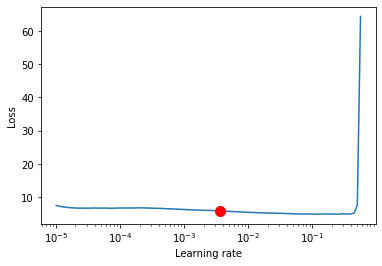

In [30]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
#use suggested optimal lr
net.hparams.learning_rate = res.suggestion()

In [36]:
net.hparams

"backcast_loss_ratio":           0.1
"context_length":                30
"dropout":                       0.1
"expansion_coefficient_lengths": [3, 7]
"learning_rate":                 0.0035481338923357554
"log_gradient_flow":             False
"log_interval":                  -1
"log_val_interval":              -1
"logging_metrics":               ModuleList(
  (0): SMAPE()
  (1): MAE()
  (2): RMSE()
  (3): MAPE()
  (4): MASE()
)
"loss":                          MASE()
"monotone_constaints":           {}
"num_block_layers":              [3, 3]
"num_blocks":                    [3, 3]
"optimizer":                     ranger
"optimizer_params":              None
"output_transformer":            EncoderNormalizer(transformation='relu')
"prediction_length":             10
"reduce_on_plateau_min_lr":      1e-05
"reduce_on_plateau_patience":    1000
"sharing":                       [True, True]
"stack_types":                   ['trend', 'seasonality']
"weight_decay":                  0.01
"wid

In [34]:
net.summarize()

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.594     Total estimated model params size (MB)

In [ ]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Fitting Model (WRONG?)

In [18]:
#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# why am i using another Trainer instance here...?
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
#     weights_summary="top",
#     gradient_clip_val=0.01,
    #callbacks=[early_stop_callback],
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.594     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  97%|█████████████▌| 30/31 [00:01<00:00, 16.83it/s, loss=4.98, v_num=0, train_loss_step=4.730]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:01<00:00, 16.30it/s, loss=4.98, v_num=0, train_loss_step=4.730, val_loss=4.4
Epoch 1:  97%|▉| 30/31 [00:01<00:00, 16.43it/s, loss=3.94, v_num=0, train_loss_step=4.030, val_loss=4.4
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:01<00:00, 15.94it/s, loss=3.94, v_num=0, train_loss_step=4.030, val_loss=4.2
Epoch 2:  97%|▉| 30/31 [00:01<00:00, 17.30it/s, loss=3.52, v_num=0, train_loss_step=3.760, val_loss=4.2
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [00:01<00:00, 16.74it/s, loss=3.52, v_num=0, train_l

# Evaluate Results

In [19]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [20]:
# Predicting on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(9.1486)

In [21]:
# look at random samples in validation set prediction
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [22]:
len(x), len(raw_predictions)

(11, 5)

In [23]:
# this encoder decoder length thing is confusing me... but yeah 41 is magic number for len(val_set)==50

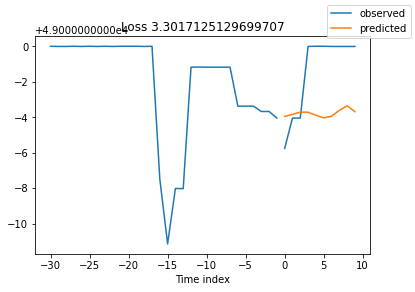

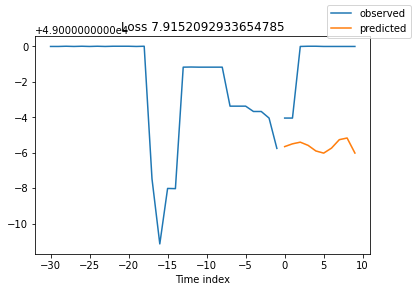

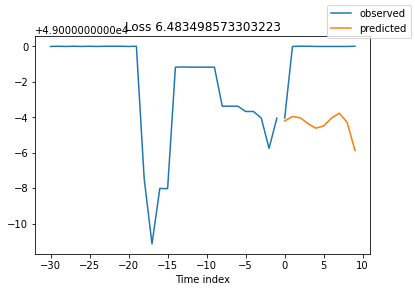

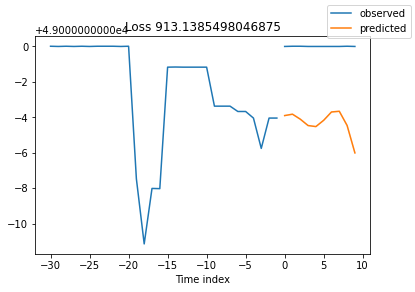

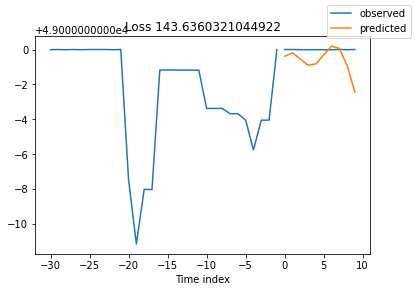

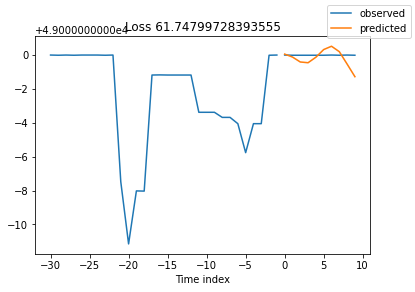

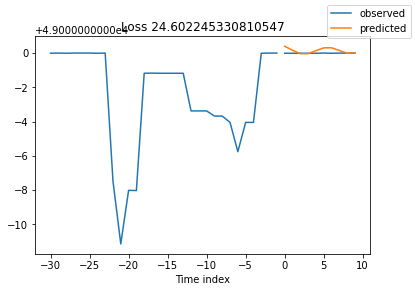

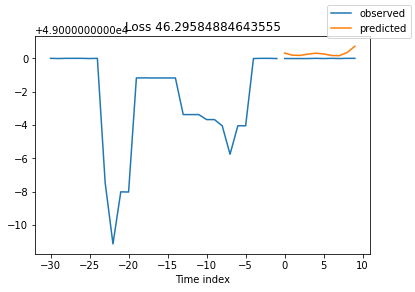

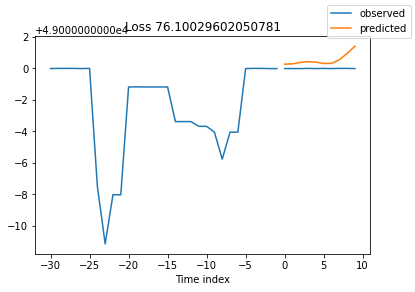

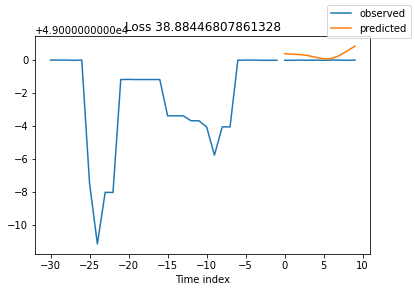

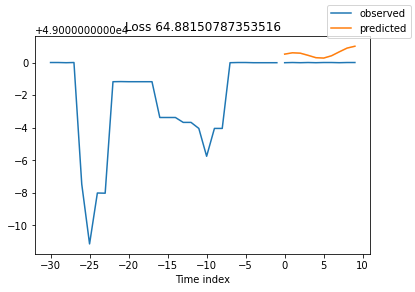

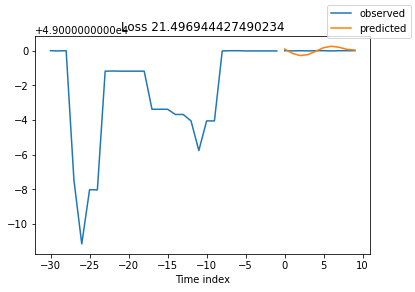

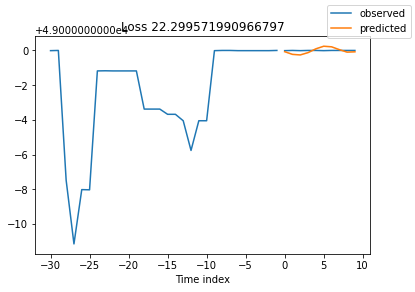

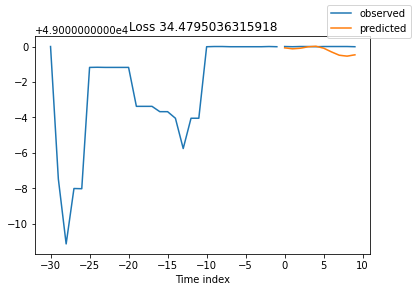

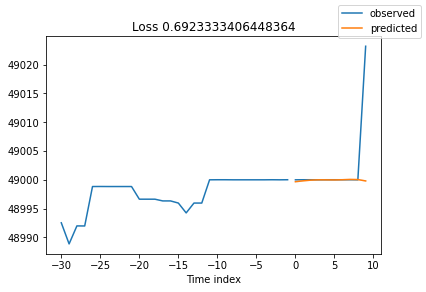

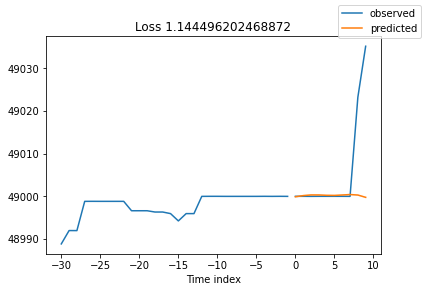

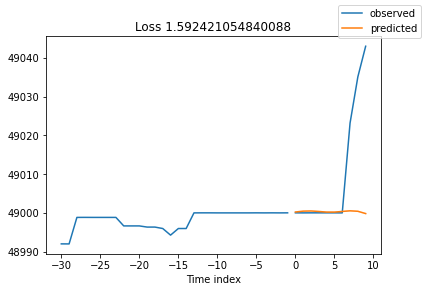

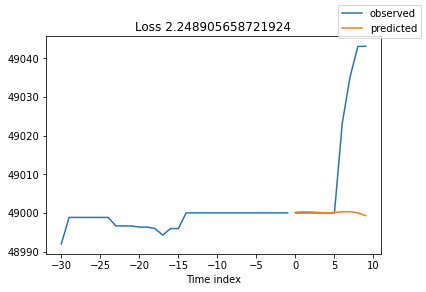

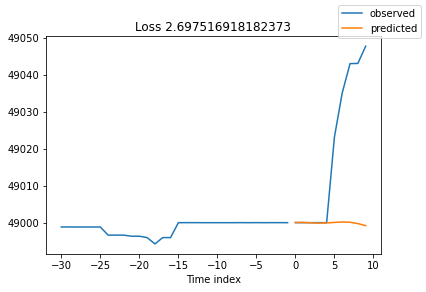

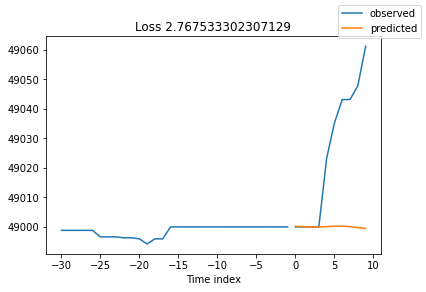

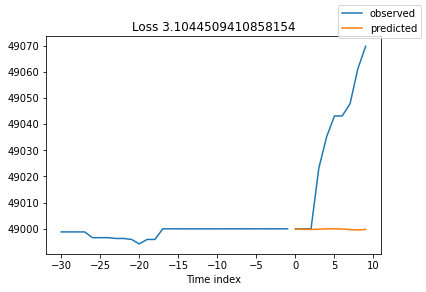

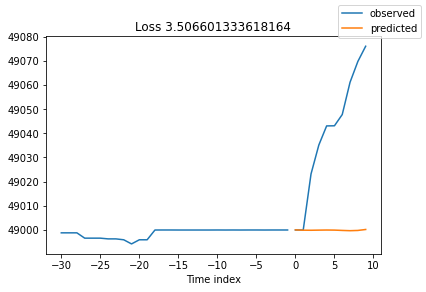

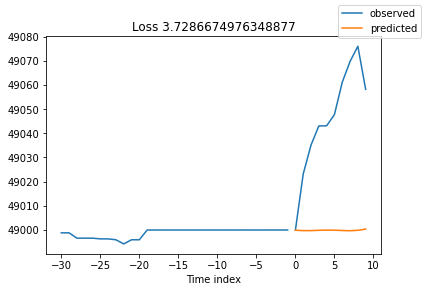

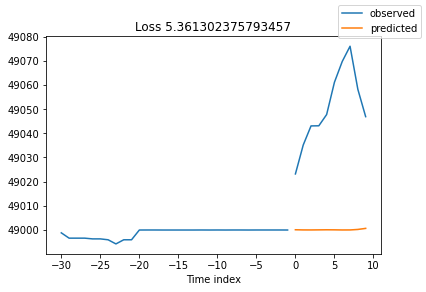

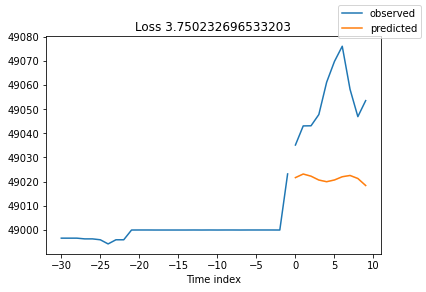

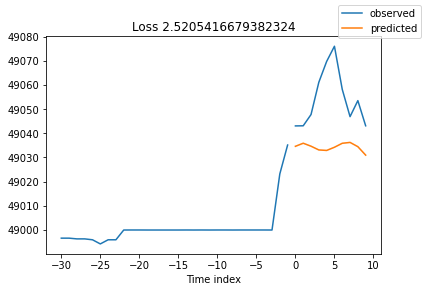

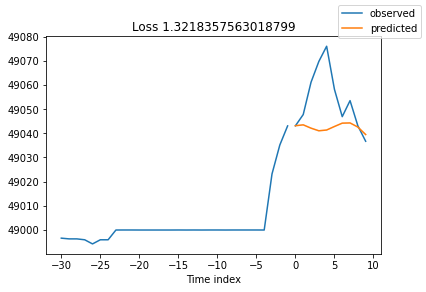

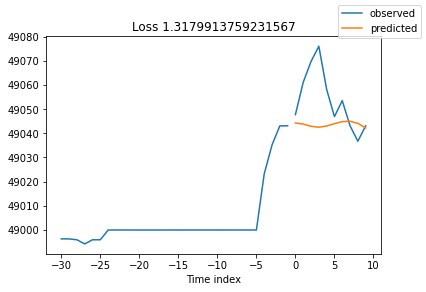

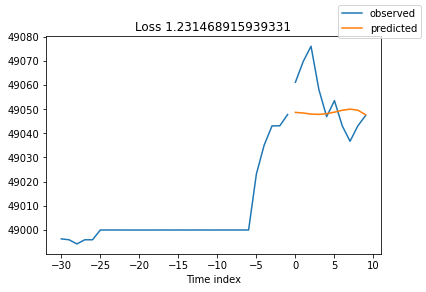

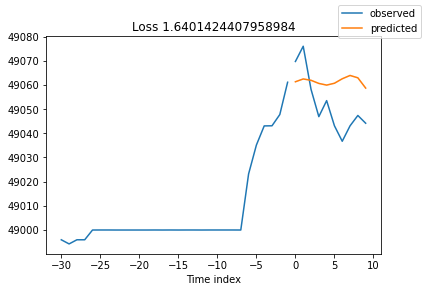

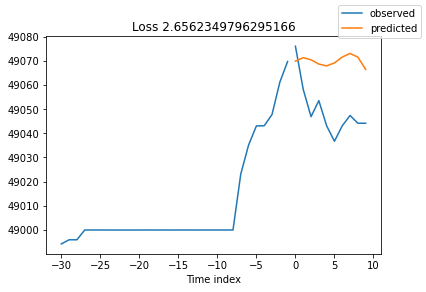

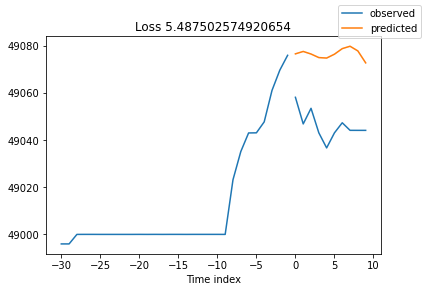

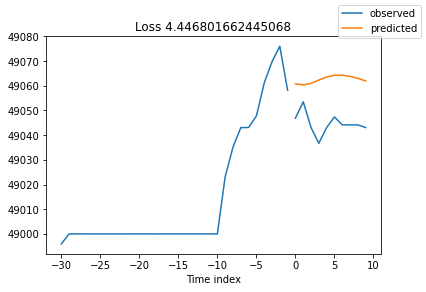

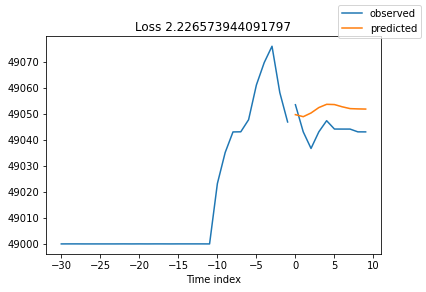

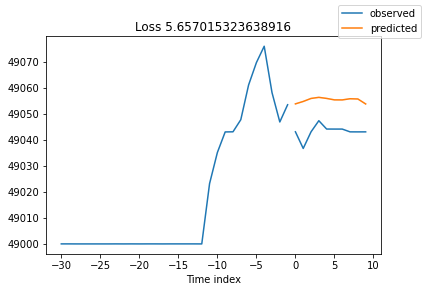

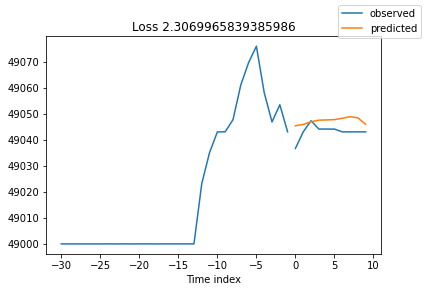

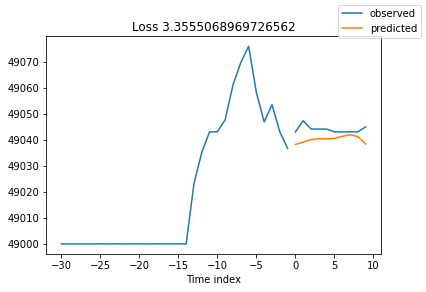

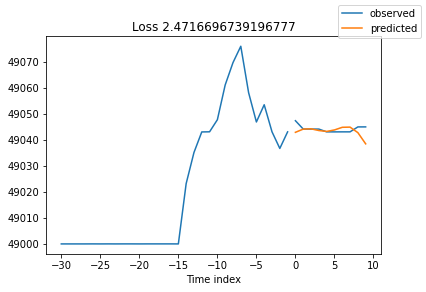

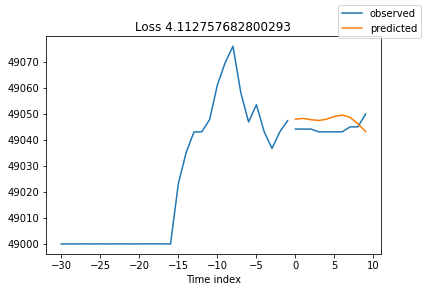

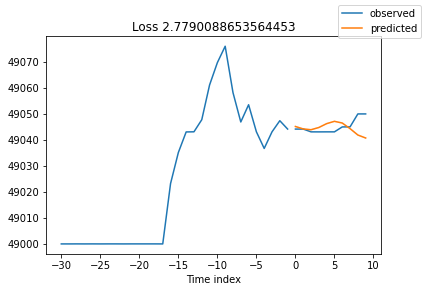

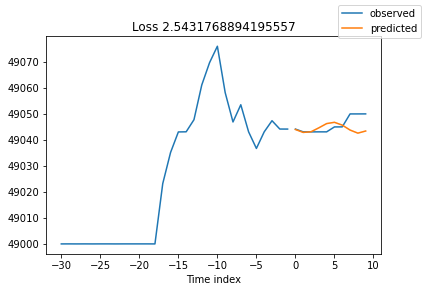

In [24]:
for idx in range(41):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

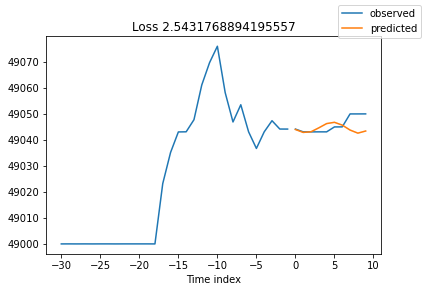

In [26]:
best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True).savefig('example_pred.png')

### Predict on testing dataset

In [27]:
os.getcwd()

'/Users/dan/Desktop/projects/uexp/ue/experiments/dan'

In [29]:
os.mkdir("experiment_plots")